In [187]:
# HyperLogLog
import math
from scipy.special import gamma 
import hashlib
import randomhash 
import random

def process_stream(file_path, m):
    """
    Process the input file stream and update registers based on hash values.
    :param file_path: Path to the input file (one word per line).
    :param m: Number of registers.
    :return: List of updated registers.
    """
    registers = initialize_registers(m)
    
    with open(file_path, "r") as file:
        for line in file:
            word = line.strip()
            if not word:  # Skip empty lines
                continue
            
            hashed_value = hash_function_binary(word)
            register_index = hashed_value & (m - 1)  
            trailing_zero_count = trailing_zeros(hashed_value)  
            registers[register_index] = max(registers[register_index], trailing_zero_count)
    
    return registers


def initialize_registers(m):
    """
    Initialize the registers for HyperLogLog.
    :param m: Number of registers.
    :return: List of registers initialized to zero.
    """
    registers = [0] * m
    return registers        


def hash_function_binary_old(value):
    """
    Hash function to convert input into a uniformly distributed 32-bit binary string.
    :param value: Input value (string or integer).
    :return: 32-bit binary string.
    """
    hashed_value = int(hashlib.sha256(value.encode()).hexdigest(), 16) & ((1 << 32) - 1)
    return int(bin(hashed_value)[2:].zfill(32))  # Convert to binary 32 bits integer    

def hash_function_binary(value):
    """
    Generate one or more independent 32-bit binary hash values using randomhash.
    :param value: Input value to hash.
    :param count: Number of independent hash values to generate.
    :return: A single 32-bit binary hash value if count=1, otherwise a list of binary hash values.
    """
    hashes = randomhash.hashes(value, count=6)
    return int(bin(hashes[5])[2:].zfill(32))  # Convert to binary 32-bit integer
                                        


def alpha_m(m):
    """
    Calculate the correcting factor α_m using the given formula in slide 48 of lecture 12 - DataStreams. 0.721?
    :param m: Number of registers (m).
    :return: Value of α_m.
    """
    # Calculate the components of the formula
    gamma_term = gamma(-1 / m)
    fraction_term = (1 - 2**(-1 / m)) / math.log(2)
    
    # Combine the terms
    alpha = (gamma_term * fraction_term) ** -m
    return alpha


def alpha_m_fixed(m):
    """
    Calculate the correcting factor α_m based on the value of m.
    Theory behind this is found at https://en.wikipedia.org/wiki/HyperLogLog.
    :param m: Number of registers (m).
    :return: Correcting factor α_m.
    """
    if m == 16:
        return 0.673
    elif m == 32:
        return 0.697
    elif m == 64:
        return 0.709
    elif m >= 128:
        return 0.7213 / (1 + 1.079 / m)
    else:
        raise ValueError("m must be at least 16 and a power of 2.")


def z_formula(R, m):
    """
    Compute Z using the harmonic mean of the registers.
    :param R: List of R_i values (trailing zeros in each register).
    :param m: Number of registers.
    :return: Raw HyperLogLog estimate Z.
    """
    harmonic_mean = sum(2 ** (-R_i) for R_i in R)
    Z = (harmonic_mean) ** -1
    return Z

def e_formula(R, m):
    """
    Compute the cardinality estimate E using Z and α_m.
    :param R: List of R_i values (trailing zeros in each register).
    :param m: Number of registers.
    :return: Estimated cardinality E.
    """
    Z = z_formula(R, m)
    alpha = alpha_m_fixed(m)
    E = alpha * m ** 2 * Z
    return E

def trailing_zeros(x):
    """
    Compute the number of trailing zeros in the binary representation of x.
    :param x: Integer value.
    :return: Number of trailing zeros.
    """
    if x == 0:
        return 32
    return (x & -x).bit_length() - 1


def hyperloglog(file_path, m):
    """
    Full HyperLogLog implementation to estimate cardinality.
    :param file_path: Path to the input file (one word per line).
    :param m: Number of registers.
    :return: Estimated cardinality.
    """
    print(f"Processing file: {file_path} with {m} registers...")
    registers = process_stream(file_path, m)
    cardinality_estimate = e_formula(registers, m)
    return cardinality_estimate

# Parse .dat file for true cardinality
def parse_dat_file(file_path):
    with open(file_path, 'r') as file:
        return sum(1 for line in file)



In [ ]:
# Recordinality
def recordinality(file_path, k):
    print(f"Processing file: {file_path} with k={k}...")
    
    # Initialize the data structure
    stream_elements = set()
    records_count = k  # Start with r_k = k
    sk_count = 0       # Start with s_k = 0

    with open(file_path, 'r') as file:
        for line in file:
            word = line.strip()
            if not word:  # Skip empty lines
                continue
            
            # Hash the word and scale the value
            hashed_value = hash_function(word)

            # If hashed value is not in the current set
            if hashed_value not in stream_elements:
                # Check if hashed_value is greater than the k-th largest in the set
                if len(stream_elements) < k or hashed_value > min(stream_elements):
                    if len(stream_elements) == k:
                        stream_elements.remove(min(stream_elements))
                        sk_count += 1  # Increment s_k when replacing the smallest
                    stream_elements.add(hashed_value)
                    records_count += 1  # Increment r_k
                    
    # Compute the cardinality estimate
    estimate = recordinality_formula(k, records_count)
    return estimate


def hash_function(value):
    hashes = randomhash.hashes(value, count=4)
    return hashes[3]

    rand_idx = random.randint(0, 9)
    hashes = randomhash.hashes(value, count=10)
    return int(bin(hashes[rand_idx])[2:].zfill(32))

def hash_function_old(value):
    return int(hashlib.sha256(value.encode()).hexdigest(), 16) % (10 ** 12)


def recordinality_formula(k, r):
    return k * ((1 + 1 / k) ** (r - k + 1) - 1)


In [ ]:
# Tests on the algorithms
import os
import pandas as pd
from IPython.display import display

# Define file paths and parameters
base_path = "/Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/"
datasets = [
    "midsummer-nights-dream",
    "war-peace",
    "valley-fear",
    "mare-balena",
    "quijote",
    "crusoe",
    "iliad",
    "dracula",
]
m = 2**14  # Number of registers for HyperLogLog
k = 2**8  # Number of records to keep for Recordinality
num_iterations = 10  # Number of iterations for averaging


def run_experiments(text_file_path, dat_file_path, m, k, num_iterations):
    true_cardinality = parse_dat_file(dat_file_path)
    hll_results = []
    rec_results = []

    for _ in range(num_iterations):
        hll_estimate = hyperloglog(text_file_path, m)
        rec_estimate = recordinality(text_file_path, k)
        hll_results.append(hll_estimate)
        rec_results.append(rec_estimate)
    
    avg_hll = sum(hll_results) / num_iterations
    avg_rec = sum(rec_results) / num_iterations

    return {
        "True Cardinality": true_cardinality,
        "HLL Estimate (avg)": avg_hll,
        "REC Estimate (avg)": avg_rec,
    }

# Run experiments for all datasets and collect results
results = []
for dataset in datasets:
    text_file_path = os.path.join(base_path, f"{dataset}.txt")
    dat_file_path = os.path.join(base_path, f"{dataset}.dat")
    dataset_results = run_experiments(text_file_path, dat_file_path, m, k, num_iterations)
    dataset_results["Dataset"] = dataset
    results.append(dataset_results)

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)
display(results_df)


Processing file: /Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/midsummer-nights-dream.txt with 16384 registers...
Processing file: /Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/midsummer-nights-dream.txt with k=256...
Processing file: /Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/midsummer-nights-dream.txt with 16384 registers...
Processing file: /Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/midsummer-nights-dream.txt with k=256...
Processing file: /Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/midsummer-nights-dream.txt with 16384 registers...
Processing file: /Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/midsummer-nights-dream.txt with k=256...
Processing file: /Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/midsummer-nights-dream.txt with 16384 registers...
Processing file: /Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/midsummer-nights-dream.txt with k=256...
Processing file:

,True Cardinality,HLL Estimate (avg),REC Estimate (avg),Dataset
0,3136,12559.324790,7873.636521,midsummer-nights-dream
1,17475,15164.130977,48791.511256,war-peace
2,5829,13146.337139,12927.257136,valley-fear
3,5670,13057.112192,16272.212509,mare-balena
4,23034,15790.046818,62937.476306,quijote
5,6245,13210.236478,19212.770468,crusoe
6,8925,13757.838890,23588.199231,iliad
7,9425,13844.265061,25926.947468,dracula


In [ ]:
# Inputs used to test on a single data stream
text_file_path = "/Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/dracula.txt"
dat_file_path = "/Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/dracula.dat"
m = 2**14 # number of registers (must be a power of 2)
k = 2**8 # number of records to keep


# Run cardinality functions 
true_cardinality = parse_dat_file(dat_file_path)
hll_estimate = hyperloglog(text_file_path, m)
rec_estimate = recordinality(text_file_path, k)

print(f"True Cardinality: {true_cardinality}")
print(f"HyperLogLog estimate: {hll_estimate}")
print(f"Recordinality estimate: {rec_estimate}")

Processing file: /Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/dracula.txt with 16384 registers...
Processing file: /Users/sinaforfang/Documents/GitHub/RA/assignment3/datasets/dracula.txt with k=256...
True Cardinality: 9425
HyperLogLog estimate: 13844.265061172653
Recordinality estimate: 25926.947468443457


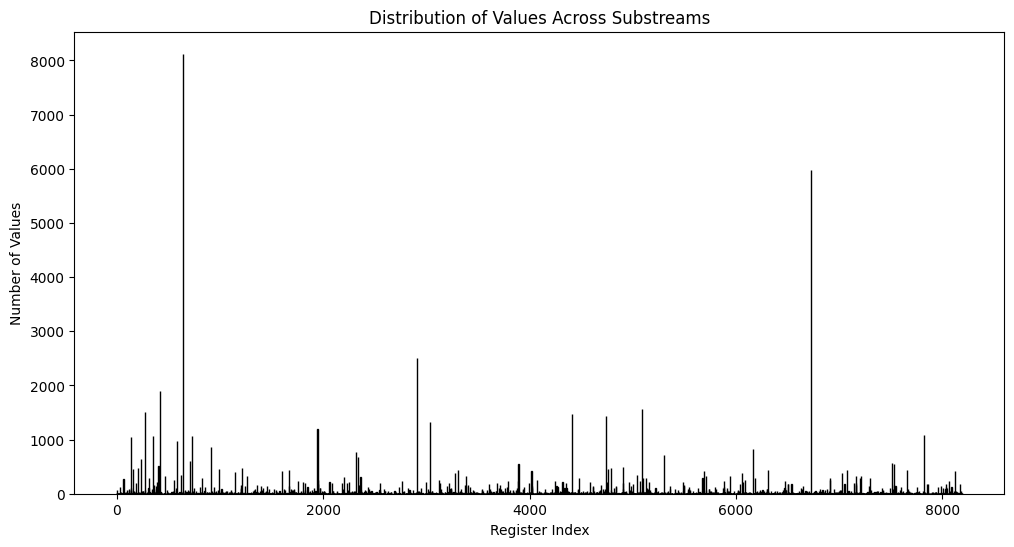

In [ ]:
# Checking the distribution of the hash function
import matplotlib.pyplot as plt

def count_substream_values(file_path, m):
    """
    Count the number of values assigned to each register in HyperLogLog.
    :param file_path: Path to the input file (one word per line).
    :param m: Number of registers.
    :return: List of counts for each register.
    """
    substream_counts = [0] * m  # Initialize counts for each register

    with open(file_path, "r") as file:
        for line in file:
            word = line.strip()
            if not word:  # Skip empty lines
                continue
            
            # Hash the word and calculate the register index
            hashed_value = hash_function_binary(word)
            register_index = hashed_value & (m - 1)
            
            # Increment the count for the corresponding register
            substream_counts[register_index] += 1
    
    return substream_counts


def plot_substream_distribution(substream_counts):
    """
    Plot the distribution of values across all substreams.
    :param substream_counts: List of counts for each register.
    """
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(substream_counts)), substream_counts, width=1.0, edgecolor='black')
    plt.title("Distribution of Values Across Substreams")
    plt.xlabel("Register Index")
    plt.ylabel("Number of Values")
    plt.show()


# Example usage
m = 2**13  # Number of registers (must match HyperLogLog)
substream_counts = count_substream_values(text_file_path, m)
plot_substream_distribution(substream_counts)

In [203]:
# Generating a synthetic data stream
import numpy as np
import random
import pandas as pd

def generate_zipfian_stream(N, n, alpha):
    """
    Generates a synthetic data stream of length N following a Zipfian distribution.
    :param N: Total number of elements in the stream.
    :param n: Number of distinct elements.
    :param alpha: Zipfian parameter (α ≥ 0).
    :return: List representing the synthetic data stream.
    """
    # Calculate normalization constant (cn)
    ranks = np.arange(1, n + 1)  # Ranks 1 to n
    weights = 1 / np.power(ranks, alpha)  # Zipfian weights
    cn = np.sum(weights)  # Normalization constant
    probabilities = weights / cn  # Probabilities for each distinct element
    
    # Normalize weights
    normalization_constant = np.sum(weights)  # Normalization constant
    probabilities = weights / normalization_constant  # Probabilities for each rank

    # Generate the distinct elements
    distinct_elements = [f"{i}" for i in range(n)]

    # Generate the stream
    stream = np.random.choice(distinct_elements, size=N, p=probabilities)

    return stream

def calculate_standard_error_hll(m):
    """
    Calculate the standard error for HyperLogLog.
    SE[Z_HLL] ≈ 1.03 / sqrt(m).
    :param m: Number of registers.
    :return: Standard error for HyperLogLog.
    """
    return 1.03 / np.sqrt(m)

def calculate_standard_error_rec(n, k):
    """
    Calculate the standard error for Recordinality.
    SE[R_k] ∼ sqrt((n / (k * e))^(1/k) - 1).
    :param n: True cardinality (distinct elements).
    :param k: Number of records kept.
    :return: Standard error for Recordinality.
    """
    return np.sqrt((n / (k * np.e))**(1 / k) - 1)

def run_zipfian_experiments(N_values, n_values, alpha_values, m, k, num_iterations):
    """
    Runs HLL and REC experiments on Zipfian synthetic data streams.
    :param N_values: List of stream lengths (N).
    :param n_values: List of distinct element counts (n).
    :param alpha_values: List of Zipfian alpha parameters.
    :param m: Number of registers for HLL.
    :param k: Number of records for REC.
    :param num_iterations: Number of iterations for averaging results.
    :return: DataFrame with experiment results.
    """
    results = []

    for N in N_values:
        for n in n_values:
            for alpha in alpha_values:
                # Generate Zipfian data stream
                stream = generate_zipfian_stream(N, n, alpha)
                true_cardinality = n

                # Write the stream to a temporary file
                with open("synthetic_zipfian_stream.txt", "w") as file:
                    for item in stream:
                        file.write(item + "\n")

                # Run multiple iterations for HLL and REC
                hll_results = []
                rec_results = []
                for _ in range(num_iterations):
                    hll_estimate = hyperloglog("synthetic_zipfian_stream.txt", m)
                    rec_estimate = recordinality("synthetic_zipfian_stream.txt", k)
                    hll_results.append(hll_estimate)
                    rec_results.append(rec_estimate)

                # Compute averages and standard errors
                avg_hll = sum(hll_results) / num_iterations
                avg_rec = sum(rec_results) / num_iterations
                se_hll = calculate_standard_error_hll(m)
                se_rec = calculate_standard_error_rec(n, k)
                error_hll = abs(avg_hll - true_cardinality) / true_cardinality
                error_rec = abs(avg_rec - true_cardinality) / true_cardinality

                # Store results
                results.append({
                    "Stream Length (N)": N,
                    "Distinct Elements (n)": n,
                    "Alpha (α)": alpha,
                    "True Cardinality": true_cardinality,
                    "HLL Estimate (avg)": avg_hll,
                    "HLL SE": se_hll,
                    "HLL Error": error_hll,
                    "REC Estimate (avg)": avg_rec,
                    "REC SE": se_rec,
                    "REC Error": error_rec
                })

    return pd.DataFrame(results)

# Parameters for the synthetic experiments
N_values = [5000, 10000, 15000]  # Different stream lengths
n_values = [1000, 5000]  # Different counts of distinct elements
alpha_values = [0.5, 1.0]  # Different Zipfian alpha parameters
m = 2**14  # Number of registers for HLL
k = 2**8  # Number of records for REC
num_iterations = 2  # Number of iterations for averaging

# Run experiments and display results
zipfian_results_df = run_zipfian_experiments(N_values, n_values, alpha_values, m, k, num_iterations)
display(zipfian_results_df)


Processing file: synthetic_zipfian_stream.txt with 16384 registers...
Processing file: synthetic_zipfian_stream.txt with k=256...
Processing file: synthetic_zipfian_stream.txt with 16384 registers...
Processing file: synthetic_zipfian_stream.txt with k=256...
Processing file: synthetic_zipfian_stream.txt with 16384 registers...
Processing file: synthetic_zipfian_stream.txt with k=256...
Processing file: synthetic_zipfian_stream.txt with 16384 registers...
Processing file: synthetic_zipfian_stream.txt with k=256...
Processing file: synthetic_zipfian_stream.txt with 16384 registers...
Processing file: synthetic_zipfian_stream.txt with k=256...
Processing file: synthetic_zipfian_stream.txt with 16384 registers...
Processing file: synthetic_zipfian_stream.txt with k=256...
Processing file: synthetic_zipfian_stream.txt with 16384 registers...
Processing file: synthetic_zipfian_stream.txt with k=256...
Processing file: synthetic_zipfian_stream.txt with 16384 registers...
Processing file: syn

,Stream Length (N),Distinct Elements (n),Alpha (α),True Cardinality,HLL Estimate (avg),HLL SE,HLL Error,REC Estimate (avg),REC SE,REC Error
0,5000,1000,0.5,1000,12056.548210,0.008047,11.056548,2287.958596,0.037647,1.287959
1,5000,1000,1.0,1000,11998.038722,0.008047,10.998039,1781.042226,0.037647,0.781042
2,5000,5000,0.5,5000,12437.195140,0.008047,1.487439,7382.016641,0.087937,0.476403
3,5000,5000,1.0,5000,12178.014156,0.008047,1.435603,4238.807632,0.087937,0.152238
4,10000,1000,0.5,1000,12061.148556,0.008047,11.061149,2705.714568,0.037647,1.705715
5,10000,1000,1.0,1000,12035.743869,0.008047,11.035744,2124.818850,0.037647,1.124819
6,10000,5000,0.5,5000,12733.453837,0.008047,1.546691,11472.108697,0.087937,1.294422
7,10000,5000,1.0,5000,12325.620974,0.008047,1.465124,6253.702202,0.087937,0.250740
8,15000,1000,0.5,1000,12061.148556,0.008047,11.061149,2368.552732,0.037647,1.368553
9,15000,1000,1.0,1000,12048.113587,0.008047,11.048114,2389.097098,0.037647,1.389097
